# Background 

Measurement of body fat can be inconvenient and expensive, thus we aim to construct a simple and accurate model which can be used to predict the body fat. In the body fat dataset, we have 252 male with measurements of percentage of their body fat and various body circumferences. 

The listed variables are percent body fat, density, age, weight, height, adiposity, neck circumference, chest circumference, abdomen circumference, hip circumference, thigh circumference, knee circumference, ankle circumference, ankle circumference, biceps circumference, forearm circumference, wrist circumference. In total, we have 14 variables.

In [9]:
#please hide this block
library(ggplot2)
library(Boruta)
library(dplyr)
library(relaimpo)
library(leaps)
library(glmnet)
library(olsrr)
library(boot)
setwd('~/Desktop/628')
data <- read.csv("BodyFat.csv",header=TRUE,sep=',')
dataset <- read.csv("BodyFat_clean.csv",header=TRUE,sep=',')

# Step 1: Preprocessing the data

By looking at the summary table of our dataset, we can have a general idea. There exists some abnormal points which be potential outliers of the bodyfat dataset: 
* The minimum value of body fat is 0.
* The minimum value of density is 0.995 which is lighter than water. 
* There is a man as old as 81.
* There is an overweight person whose weight is 363Ibs.

In order to detect all the outliers, we first consider Siri's Equation,   $$ BodyFat = \frac{495}{Density}-450  $$
We plot the actual bodyfat percentage in the dataset against the bodyfat percentage calculated by Siri's Equation. From the plot, we can tell that point 48, 76, 96 and 182 are far off the line. 
* For the point 48, the bodyfat caluculated by Siri is 14.1%, so we change 6.4% to 14.1% ; for the point 76, the bodyfat calculated by Siri is 14.1%, so we change 18.3% to 14.1%.
* For the point 96, the bodyfat calculated by siri is 0.4%, while other circumferences measurements are resonable, so the density value may be incorrectly recorded, thus we decide to keep the original BodyFat value.
* For the point 182, the bodyfat calculated by siri is -3.6%, thus the records of bodyfat and density may be wrong, thus we can use the information of other measurements to impute this datapoint. We check the correctness of ADIPOSITY, HEIGHT and WEIGHT by using the equation 
$$ADIPOSITY = 703\cdot \frac{WEIGHT(lbs)}{HEIGHT^2(inches^2)} = 703\cdot 118.5/68^2 = 18.02$$ which is approximately equal to 18.1. So we conclude that the value of ADIPOSITY, HEIGHT and WEIGHT are true. Next we use ADIPOSITY to evaluate BODYFAT.We estimate one's body by using $$BodyFat = 1.2*BMI + 0.23 * Age -10.8 Sex -5.4 ^{[1]}$$ thus we impute the value 14.7%.

In addition, by looking at the boxplot, we easily identify there are two people whose measurements seem to be very large compared to other datapoints, point 39 (large circumferences) and 42 (extremely short).
* For the point 39, all the circumference measurements are relatively large to other people, so we decide to remove this point.
* For the point 41, many of the circumference measurements are relatively large to other people, so we decide to delete the data.
* For the point 42, the height is 29.5 while other measurements are reasonable, thus we use BMI formula to recalculate its value and impute it as 69.43.
* For the point 216, the density is lower than 1 while the bodyfat is extremely high, some of the measurements also higher than normal, so we delete the data.

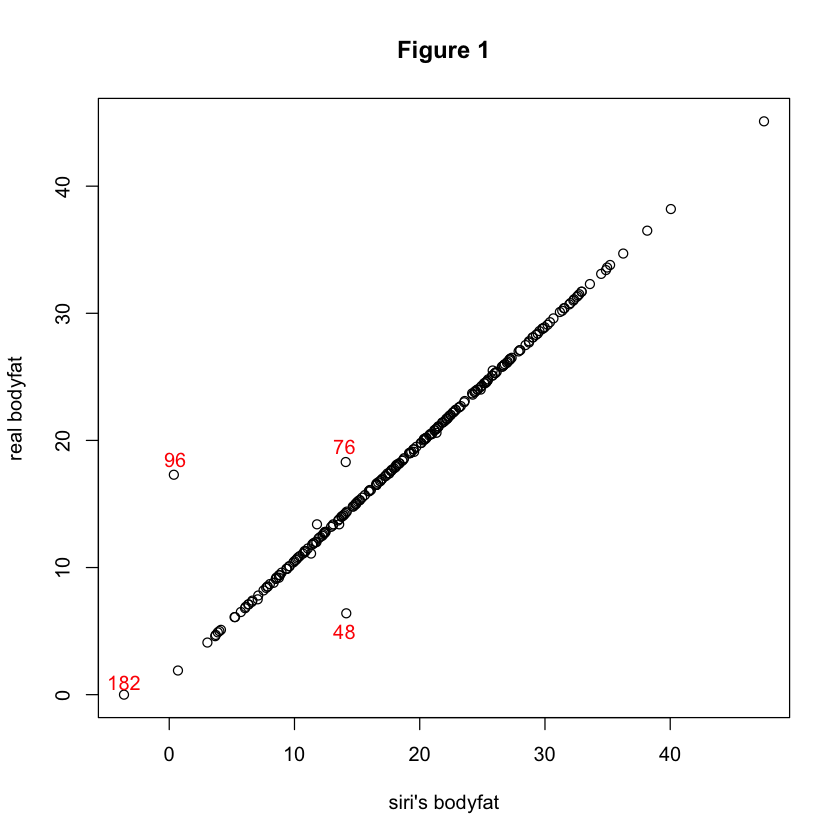

In [11]:
#Siri's Equation
siri=495/data$DENSITY-450
plot(data$BODYFAT ~ siri, ylab = "real bodyfat", xlab = "siri's bodyfat", main = "Figure 1")
text(-3.6,1,"182",col = "red",);text(0.5,18.5,"96",col = "red");text(14,19.5,"76",col = "red");text(14,5,"48",col = "red")

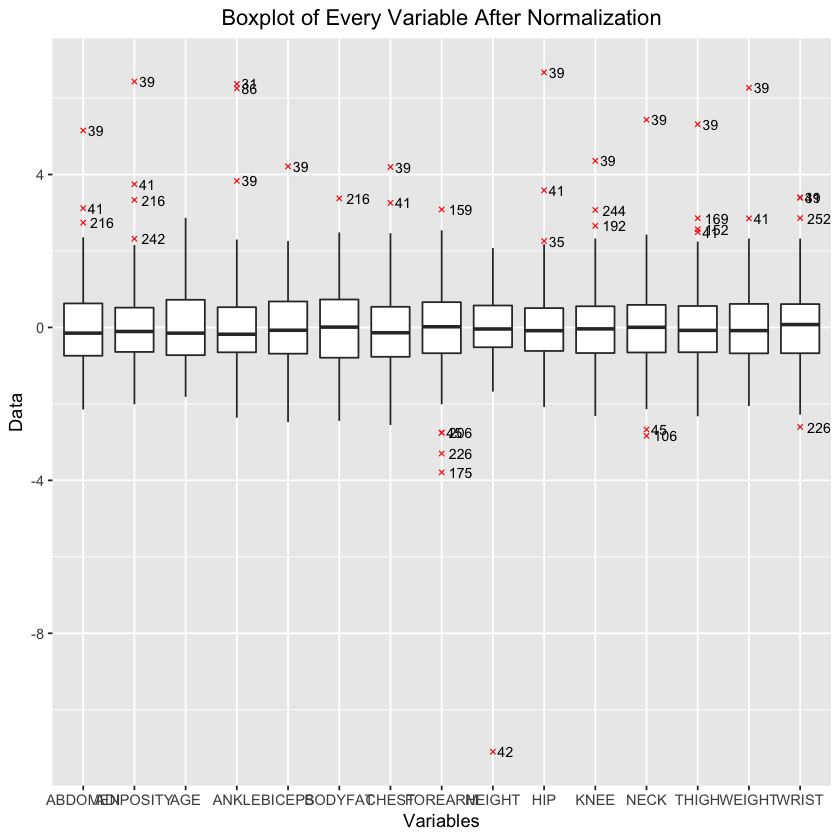

In [10]:
data_reshape <- scale(data$BODYFAT, center = T, scale = T)
cname <- colnames(data)[c(-1,-3)]
for (i in 4:(length(cname)+2)) {
  data_reshape <- c(data_reshape, scale(data[,i], center = T, scale = T))
}
data_2 <- data.frame(data = data_reshape, variable = rep(cname, each = nrow(data)), 
                     idno = rep(data$IDNO, length(cname)))
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}
data_2 %>% 
  group_by(variable) %>%
  mutate(outlier = ifelse(is_outlier(data), idno, as.numeric(NA))) %>%
  ggplot(., aes(x = variable, y = data)) + 
  geom_boxplot(outlier.color = "red", outlier.size = 1, outlier.shape = 4) + 
  geom_text(aes(label = outlier), na.rm = TRUE, hjust = -0.3, size = 3) +
  labs(title = "Boxplot of Every Variable After Normalization", x = "Variables", y = "Data") +
  theme(plot.title = element_text(hjust = 0.5))

In [5]:
data[c(39,41,42,48, 76, 96, 182,216),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
41,41,33.1,1.0217,45,262.75,68.75,39.1,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4
42,42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
48,48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
96,96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
182,182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
216,216,45.1,0.9950,51,219.00,64.00,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [45]:
#Full Model Adjustment
model <- lm(BODYFAT~AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+ADIPOSITY,dataset)
model_dep <- lm(ADIPOSITY~HEIGHT+WEIGHT,dataset)
res <- residuals(model_dep)
model_adj <- lm(BODYFAT~AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+res,dataset)

# Step 2: Feature Selection

First, we fit a linear regression model of all the 14 variables on the response variable, the bodyfat percentage. The P valus of Abdomen, age and wrist are significant. The adjusted R-squared is 0.7298, the F statistics is 49.23, and the p-value is <2.2e-16. There are two concerns here: 1. Some of the body circumferences measurement seem to be useless and less important, so we need to do further feature selection over the 14 variables. 2.While looking at the variables, there is clearly strong association between weight, height and adiposity, thus we may need to deal with the dependencies in the dataset.

In order to eliminate the dependencies in weight, height and adiposity, we regress the weight and height on the adiposity. In the summary table of Adiposity ~ Weight + Height, the adjusted R-squared is 0.9868, the F stats is 9324, and the p-value is <2.2e-16. Then, we add the residuals of the model as a predictor in our full model, and remove the adiposity. Then, we refit our regression model, the adjusted R-squared is 0.7298, the F-Statistics is 49.23, and the p-value is <2.2e-16. 

Next, we move to the feature selection. We adopted several approaches here: BIC selection, Lasso feature selection, Boruta Algorithm Selection, and relative importance of different vairables contribution to R-square. Here is the overview of feature Selection Result:

 |Approach         | Selected Features            
| ------------- | -------------:|
| P Value   |Abdomen, Wrist  |
| R-Squared Relative Importance   |Abdomen, Chest | 
| BIC |Abdomen, Height, Wrist      |  
| Subset Selection |Abdomen, Weight   | 
| Lasso |Abdomen, Height|
| Boruta Algorithm |Abdomen, Chest|

## Boruta Algorithm
We use Boruta algorithm to capture all the important features in our dataset with respect to an outcome variable. The selected feature are Abdomen and Chest. 

In [61]:
#boruta_output <- Boruta(BODYFAT ~ AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+res, data=na.omit(dataset), doTrace=0)  
#boruta_signif <- getSelectedAttributes(boruta_output, withTentative = TRUE)
#print(boruta_signif)
#roughFixMod <- TentativeRoughFix(boruta_output)
#boruta_signif <- getSelectedAttributes(roughFixMod)
#imps <- attStats(roughFixMod)
#imps2 = imps[imps$decision != 'Rejected', c('meanImp', 'decision')]
#Top five variables
#head(imps2[order(-imps2$meanImp), ])
#Graph
#plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance") 

<img src="boruta.png" width=400>

## BIC Stepwise Backward Selection

The selected model is $$BODYFAT\sim WRIST+HEIGHT+ABDOMEN$$

In [54]:
# model_bic=step(model_adj,direction = "both",k=log(nrow(dataset)))

## Lasso Regression
Lasso regression allows you to do variable selection and regularization while you are building the model. We applied normalization to every features the data set has, so every feature has the same scale now. Below, we listed three models with two variables after lasso selection. We decide to use the last with largest $R^2$ which uses adbomen and height as two predictors.

In [48]:
#Lasso Selection
features <- as.matrix(dataset[,c(-1,-2,-3)])
response <- as.matrix(dataset[,2])
model_lasso <- glmnet(x = features, y = response, family = "gaussian", nlambda = 50, alpha = 1, standardize = T)
#cat("Results of Lasso regression with two variables:\n")
results <- data.frame(variable = model_lasso$df, R_squared = model_lasso$dev.ratio,
                      lambda = model_lasso$lambda)
print(results[c(10,11,12),])

   variable R_squared    lambda
10        2 0.6491171 1.1409567
11        2 0.6664666 0.9454456
12        2 0.6783776 0.7834366


## Best Subset Selection
Here we choos best subset selection to select the top 2 significant variables and see if it is coherent with the result of other selection methods. The results are showed above. It automatically listed eight best models with variables number from 1 to 8. The selected two variables are Weight and Abdomen. 

In [49]:
#Subset Selection
dataset_bss <- dataset[,c(-1,-3)]
model_bss <- regsubsets(BODYFAT ~ AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+res, data = dataset_bss)
summary(model_bss)$outmat

,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,res
1 ( 1 ),,,,,,*,,,,,,,,
2 ( 1 ),,*,,,,*,,,,,,,,
3 ( 1 ),,*,,,,*,,,,,,,*,
4 ( 1 ),*,,*,,,*,,,,,,,*,
5 ( 1 ),*,,*,,*,*,,,,,,,*,
6 ( 1 ),*,,*,,*,*,,,,,*,,*,
7 ( 1 ),*,,*,*,*,*,,,,,*,,*,
8 ( 1 ),*,,*,*,*,*,,,,,*,*,*,


## R-Sqaured Relative Importance


In [50]:
relImportance <- calc.relimp(model_adj, type = "lmg", rela = F)  
# Sort
#cat('Relative Importances: \n')
sort(round(relImportance$lmg, 3), decreasing=TRUE)
#bootsub <- boot.relimp(BODYFAT~., data=dataset,b = 1000, type = 'lmg', rank = TRUE, diff = TRUE)
#plot(booteval.relimp(bootsub, level=.95))

ABDOMEN   CHEST  WEIGHT     HIP   THIGH     AGE    KNEE    NECK  HEIGHT  BICEPS 
  0.251   0.093   0.071   0.069   0.045   0.040   0.032   0.031   0.030   0.028 
  WRIST FOREARM   ANKLE     res 
  0.026   0.015   0.008   0.006

# Step 3: Model Selection

After the feature selection, we have several candidate models:
  
 |Models         | R-Squared           | F Statistics   
 | ------------- |:-------------:| ------:|
| BODYFAT~ABDOMEN+WRIST+HEIGHT | 0.7229 |  218.4 |
| BODYFAT~ABDOMEN+CHEST    | 0.6827 | 269.9 |
| BODYFAT~ABDOMEN+HEIGHT     | 0.7028      | 296.7  |
| BODYFAT~ABDOMEN+WEIGHT |   0.7115    |   309.3  |
| BODYFAT~ABDOMEN+WRIST  |  0.7079     |  304      |
| BODYFAT~ABDOMEN        |   0.6664          |   500   |

We wanna find the optimized model by 10-fold cross validation. The MSE of four models are as below.

  |Models         | MSE (Test)           | MSE(Train)   
| ------------- |:-------------:| ------:|
| BODYFAT~ABDOMEN+WRIST+HEIGHT | 16.40444 | 16.37404  |
| BODYFAT~ABDOMEN+CHEST    | 18.66096 | 18.63678 |
| BODYFAT~ABDOMEN+HEIGHT     | 17.52315      | 17.49791  |
| BODYFAT~ABDOMEN+WEIGHT |   16.97938    |   16.95667  |
| BODYFAT~ABDOMEN+WRIST  |  17.18307     |  17.16051      |
| BODYFAT~ABDOMEN        |   19.55060         |   19.53293   |


In [51]:
# model with weight and abdomen
model_weight_abdo <- glm(BODYFAT ~ WEIGHT + ABDOMEN, data = dataset)
# model with height and abdomen
model_height_abdo <- glm(BODYFAT ~ HEIGHT + ABDOMEN, data = dataset)
# model with chest and abdomen
model_chest_abdo <- glm(BODYFAT ~ CHEST + ABDOMEN, data = dataset)
# model with wrist and abdomen
model_wrist_abdo <- glm(BODYFAT ~ WRIST + ABDOMEN, data = dataset)
model_bic <- glm(BODYFAT ~ WRIST + ABDOMEN + HEIGHT, data = dataset)
# model with abdomen only
model_abdomen <- glm(BODYFAT ~ ABDOMEN, data = dataset)
# repeat 10-fold cross validation for 100 times
n = 400
cv.err.weight <- matrix(0, n, 2)
cv.err.height <- matrix(0, n, 2)
cv.err.chest <- matrix(0, n, 2)
cv.err.wrist <- matrix(0, n, 2)
cv.err.abdomen <- matrix(0, n, 2)
cv.err.bic <- matrix(0, n, 2)
times <- rep(0, 6)
for (i in 1:n){
    cv.err.weight[i,] <- cv.glm(dataset, model_weight_abdo, K = 10)$delta
    cv.err.height[i,] <- cv.glm(dataset, model_height_abdo, K = 10)$delta
    cv.err.chest[i,] <- cv.glm(dataset, model_chest_abdo, K = 10)$delta
    cv.err.wrist[i,] <- cv.glm(dataset, model_wrist_abdo, K = 10)$delta
    cv.err.abdomen[i,] <- cv.glm(dataset, model_abdomen, K = 10)$delta
    cv.err.bic[i,] <- cv.glm(dataset, model_bic, K = 10)$delta
    min = which.min(c(cv.err.weight[i,2], cv.err.height[i,2], cv.err.chest[i,2], 
                      cv.err.wrist[i,2], cv.err.abdomen[i,2], cv.err.bic[i,2]))
    times[min] = times[min] + 1
}
cv.results <- data.frame(model = c("Weight&Abdomen", "Height&Abdomen", "Chest&Abdomen", "Wrist&Abdomen","Abdomen","Abdomen&Wrist&Height"),
                         Training = rep(0,6), Testing = rep(0,6), Times = times)
cv.results[1,c(2,3)] = c(mean(cv.err.weight[,1]), mean(cv.err.weight[,2]))
cv.results[2,c(2,3)] = c(mean(cv.err.height[,1]), mean(cv.err.height[,2]))
cv.results[3,c(2,3)] = c(mean(cv.err.chest[,1]), mean(cv.err.chest[,2]))
cv.results[4,c(2,3)] = c(mean(cv.err.wrist[,1]), mean(cv.err.wrist[,2]))
cv.results[5,c(2,3)] = c(mean(cv.err.abdomen[,1]), mean(cv.err.abdomen[,2]))
cv.results[6,c(2,3)] = c(mean(cv.err.bic[,1]), mean(cv.err.bic[,2]))
print(cv.results)

                 model Training  Testing Times
1       Weight&Abdomen 16.80562 16.78358     1
2       Height&Abdomen 17.43145 17.40649     0
3        Chest&Abdomen 18.46564 18.44130     0
4        Wrist&Abdomen 16.98726 16.96541     0
5              Abdomen 19.36233 19.34486     0
6 Abdomen&Wrist&Height 16.29474 16.26408   399


# Step 4: Final Model Interpretation and Diagnostic

Our selected model is $$BODYFAT \sim -42+0.9ABDOMEN-0.1WEIGHT$$ The bodyfat can be calculated as the above formula. The rule of thumb:
* If you want to calculate your bodyfat, measure your abdomen and weight circumference, and calculate 90% abdomen minus 10% weight and minus 42, then you will have your estimated bodyfat.

## Model Interpretation
As we noticed that the coefficient of abdomen is 0.89470 meaning that as abdomen increased by one unit, the bodyfat will be increased by 0.89470, while as weight increased by one unit, the bodyfat will be decreased by 0.1241. The negative coefficient of weight can be explained that there is tradeoff between abdomen and weight. In real life, skinny people may have high bodyfat.

## Model diagnostic
1.Linear relationship: from the Residuals vs Fitted value plot, an approxmately horizontal line, but no distinct pattern is an indication for a linear relationship, which satisfy linearity assumption.  

2.Multivariate normality: residuals points mostly follow the dashed line except few head and tail points which is acceptable to retain the normality assumption.  

3.No multicollinearity: the VIF of Abdomen and Weight is 4.24  which is below 5, so there is no significant effect of multicollinearity. 

4.Homoscedasticity: In the residual plot, the assumption is that variance is a constant can be retained since there is no certain trend or pattern of variance with index increase.  

5.Influential points: in the diagnostics plots, there are several points which stand out, 181 and 206. We remove the two points one by one, however, the increase of R-squared is very limited, so we decide to keep the two points.

6.Robustness: we rebuild our model including 39th observation which is a outlier and compare the model with our original model to test robustness. We realize that the coefficients change is smaller than 0.01 and the p-values are still significant.

In [60]:
#final <- lm(BODYFAT~ABDOMEN+WEIGHT,dataset)
#par(mfrow = c(2,2))
#plot(final)
#ols_plot_cooksd_bar(final)

<img src="diag.png" width=400>

# Strength and Weakness
## Strength

* Our model is simple, explicit and interpretable. 
* We only have two predictors which makes the interpretation easier. 

## Weakness

* This dataset contains biased sample, thus our model may only be applicable to limited range of people. Our model can only be used be predict male bodyfat, since our dataset only contains male observations; our model only contains male age from 20 to 80, and the distribution over various age difference are uneven, thus our model may not be effectively generalized.

* The coefficient of weight is negative. If one has light weight but with large abdomen circumference measurements, our model prediction may not be accurate.


# Contribution

* Fangfei Lin: Jupytor Notebook Editing, Buruto Model Building, Slides Editing
* Lu Chen: Data Cleaning, Slides Editing, Reference Research, Outlier detection
* Qintao Ying: Lasso Regression, R-shiny, Cross-Validation
* Yansong Mao: Model Diagnostic, Stepwise Methods, Model Selection

# Reference
[1] Janjic Jelena, Baltic ZM, Glisic Milica, Icanovic Jelena, Boskovic Marija, Popovic Milka and Lovrenovic Mirjana,  $ Relationship\ between\ Body\ Mass\ Index\ and\ Body\ Fat\ Percentage\ among\ Adolescents\ from\ Serbian\ Republic $, 2016

